<a href="https://colab.research.google.com/github/RossPereira/DetectarDoencasPulmonares/blob/main/DetectarDoencasPulmonares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**PROBLEMA:**



##**Importando as Bibliotecas e Dados**

In [ ]:
# Caso tenha algum problema com a importação do keras instale a versão abaixo do tensorflow
!pip install tensorflow==2.7

In [43]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
xray_directory = '/content/drive/MyDrive/Portfolio/Bases/DetectarDoencasPulmonares/Dataset'

**Classes de Imagens para o Modelo:**<br>
0 - Covid 19<br>
1 - Pessoas sem nenhuma doença<br>
2 - Pneumonia Viral<br>
3 - Pneumonia Bacteriana<br>

In [5]:
# Acessando as Imagens e Convertendo os pixels delas para uma scala entre 0 e 1 assim elas podem ser passadas para redes neurais
image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
# 40 imagens por batchs com tamanho de 256 por 256
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [7]:
train_images, train_labels = next(train_generator)

In [8]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

##**Visualizando os Dados**

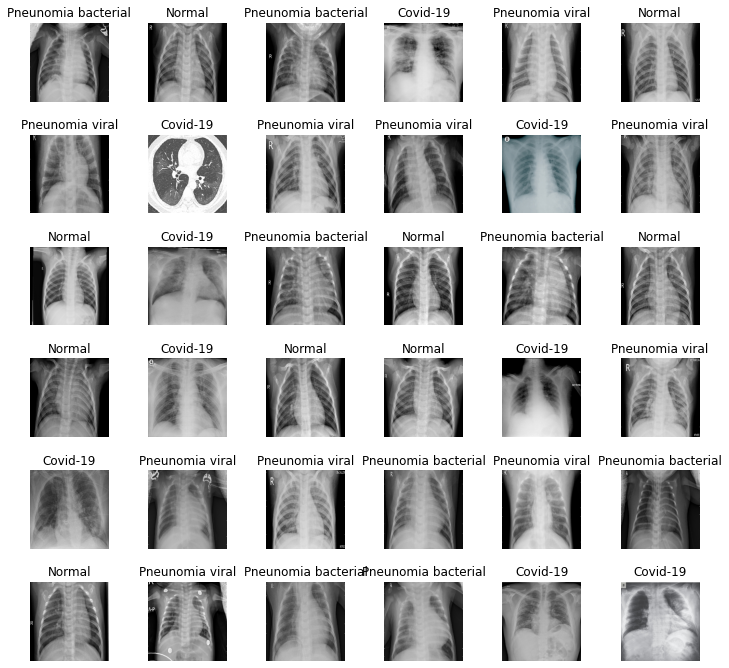

In [9]:
# Criando uma visualização de 6 linhas e 6 colunas (36 imagens)
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

#**SOLUÇÃO:**

Será usada uma rede neural convolucional que explicando a grosso modo recebe a imagem, as camadas internas da rede extraem caracteristicas dessas imagens e passam essas caracteristicas para a camada de saída responsável por classificar entre as 4 categorias estabelecidas acima

**Carregando a Rede Neural Resnet e fazendo a transferência de aprendizagem**

In [10]:
# a Resnet é uma arquitetura de rede neural que foi treinada com uma base de 11 milhoes de imagens chamada imagenet, nesse caso sera usada a transferencia de aprendizagem para o nosso problema
# Carregando a rede com os pesos pré treinados
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 0s 0us/step


In [11]:
# Visualizando as camadas da rede neural
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [12]:
# Verificando a Quantidade de Camadas e 'Congelando' os pesos para evitar o retreino
len(base_model.layers)

175

In [13]:
# -10 significa que as ultimas 10 camadas os pesos irão ser alterados e nos mesmos iremos treinar para o modelo se adaptar ao tipo das nossas imagens
for layer in base_model.layers[:-10]:
  layers.trainable = False

**Construção e treinamento do modelo de deep learning**

In [14]:
# Criando as camadas de saida
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model) # foram feitos testes com 128 mas os resultados de 256 foram melhores
head_model = Dropout(0.2)(head_model) # zera 20% da camada densa para evitar o overfiting
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model) #função softmax usada para problemas com mais de uma classe, 2 classes geralmente se utiliza sigmoid

In [15]:
# Efetivamente criando o modelo
model = Model(inputs = base_model.input, outputs = head_model)

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

In [17]:
# Salvando o modelo
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [18]:
# Alteramos o batch_size de 40 para 4 pois se mantermos 40 irá dar um erro por conta da pouca quantidade de imagens
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [19]:
history = model.fit_generator(train_generator, epochs = 25, 
                              callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.0108 - accuracy: 0.7199

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


133/133 [==============================] - 200s 1s/step - loss: 1.0108 - accuracy: 0.7199
Epoch 2/25
133/133 [==============================] - 16s 118ms/step - loss: 0.4232 - accuracy: 0.8722
Epoch 3/25
133/133 [==============================] - 16s 118ms/step - loss: 0.3316 - accuracy: 0.9154
Epoch 4/25
133/133 [==============================] - 16s 118ms/step - loss: 0.2391 - accuracy: 0.9530
Epoch 5/25
133/133 [==============================] - 16s 120ms/step - loss: 0.2987 - accuracy: 0.9511
Epoch 6/25
133/133 [==============================] - 16s 120ms/step - loss: 0.3052 - accuracy: 0.9774
Epoch 7/25
133/133 [==============================] - 16s 124ms/step - loss: 0.1653 - accuracy: 0.9774
Epoch 8/25
133/133 [==============================] - 16s 121ms/step - loss: 0.0809 - accuracy: 0.9887
Epoch 9/25
133/133 [==============================] - 16s 118ms/step - loss: 0.0565 - accuracy: 0.9868
Epoch 10/25
133/133 [==============================] - 16s 119ms/step - loss: 0.1072 -

**Avaliação da Rede Neural**

In [21]:
# Pegando as informações de loss e accuracy do histotico das 25 epocas nos dados de treinamento
history.history.keys()

dict_keys(['loss', 'accuracy'])

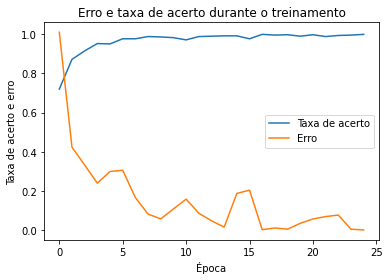

In [22]:
# Plotando em um gráfico o historico
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

**Avaliação com a Base de dados de Teste**

In [23]:
test_directory = '/content/drive/MyDrive/Portfolio/Bases/DetectarDoencasPulmonares/Test'

In [24]:
os.listdir(test_directory)

['0', '1', '3', '2']

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [28]:
evaluate = model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [29]:
# Verificando resultado na matriz [erro, accuracy]
evaluate

[5.649054527282715, 0.824999988079071]

In [30]:
# Codificação para verificar as previsoes vs as respostas reais e gerar uma matriz de confusao mais a frente
prediction = []
original = []
image = []

# Percorre todas as imagens em todos os diretorios
# Redimensiona a imagem
# Aplica a rede neural a imagem redimencionada 
# Recolhe os resultados e aplica as listas

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [31]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 1, 0, 2, 2, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3]


In [32]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [34]:
# Verificando o Accuracy com os dados de teste
accuracy_score(original, prediction)

0.825

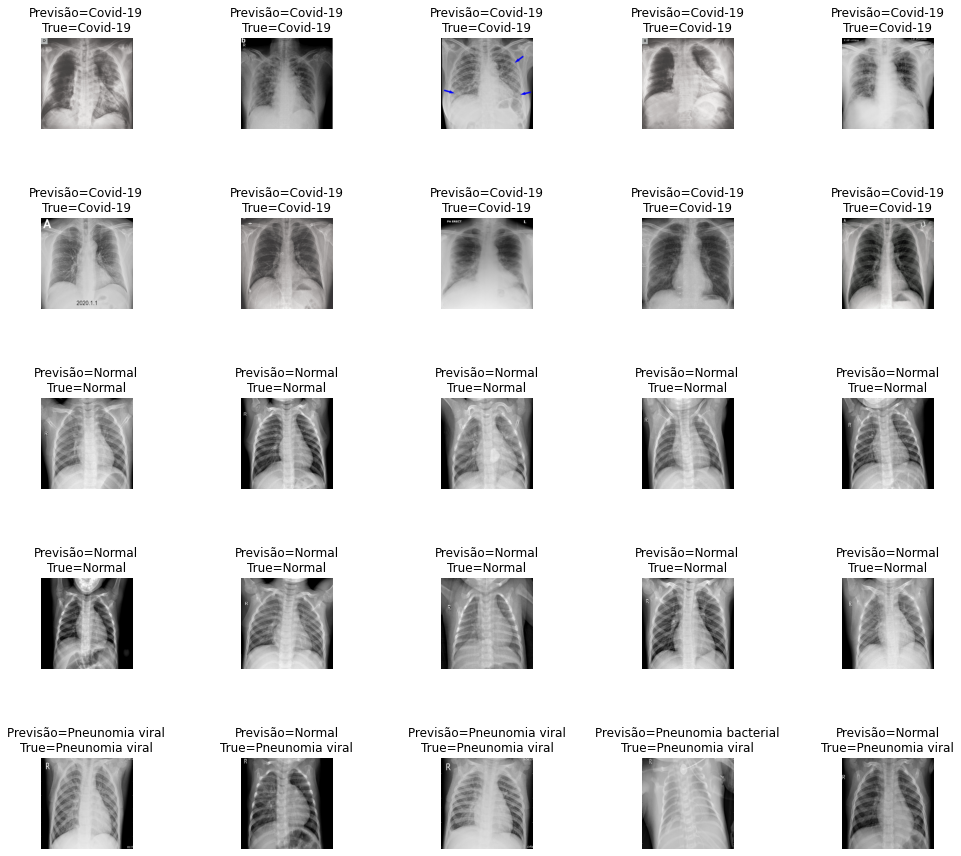

In [39]:
# Plotando gráficos com as imagens de teste e no topo podemos ver a previsão para aquela imagem e a classificação real dela
fig, axes = plt.subplots(5, 5, figsize=(16,16))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace =1.2)

In [40]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

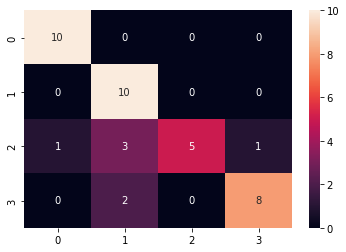

In [41]:
# Gerando a matrix de confusão
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [42]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.67      1.00      0.80        10
           2       1.00      0.50      0.67        10
           3       0.89      0.80      0.84        10

    accuracy                           0.82        40
   macro avg       0.87      0.82      0.82        40
weighted avg       0.87      0.82      0.82        40



Um desempenho interessante considerando o número baixo de imagens para treino e testes um passo futuro seria aumentar as amostras das bases de dados

**Realizando a classificação de apenas 1 imagem (simulação do modelo em produção)**

In [44]:
# Carregando o modelo salvo
model_loaded = load_model('/content/weights.hdf5')

In [45]:
# Verificando a estrutura da rede neural
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [46]:
# Carregando 1 imagem da base de teste
img = cv2.imread('/content/drive/MyDrive/Portfolio/Bases/DetectarDoencasPulmonares/Test/0/radiol.2020200490.fig3.jpeg')

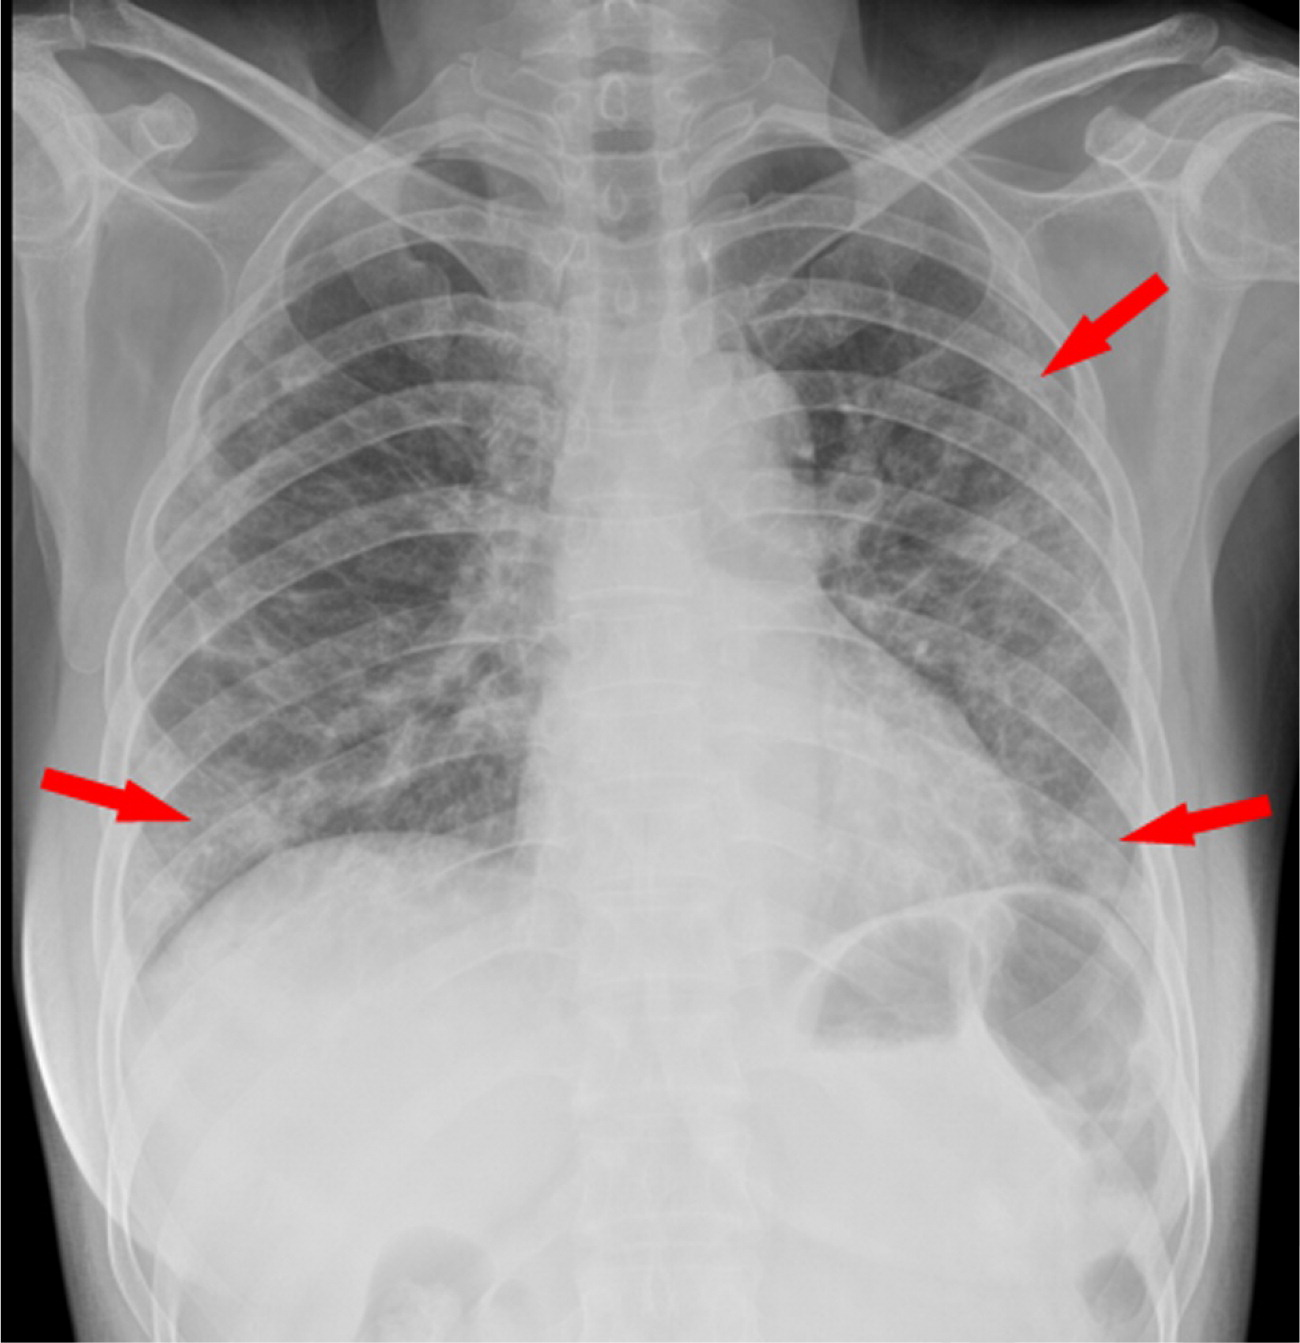

In [47]:
# Visualizando a imagem
from google.colab.patches import cv2_imshow
cv2_imshow(img)

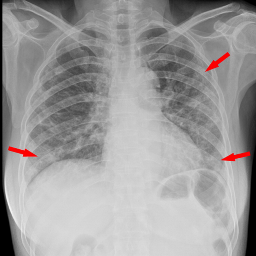

In [48]:
# Redimensionando
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [49]:
# normalizando os valores para escala entre 0 e 1 para submissao a rede
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [50]:
# Adicionado a informação de batch nese caso é esse primeiro numero 1 nos parenteses que indica o numero de imagens
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [51]:
# Passando a imagem para o modelo carregado ele gera uma matriz com as probabilidades da imagem ser de cada classe
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7187907e-10]],
      dtype=float32)>

In [ ]:
# Isolando apenas o valor de probabilidade maior 
predict2 = np.argmax(predict)
predict2

In [52]:
predict2 = np.argmax(predict)
predict2

0

In [53]:
labels_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

Foi classificado corretamente como uma imagem de covid 19